In [1]:
%%capture
%pip -q install diffusers accelerate torch-snippets torchinfo lovely_tensors

In [2]:
from diffusers import DiffusionPipeline
import torch

In [3]:
# Define the Stable Diffusion XL pipeline
pipeline = DiffusionPipeline.from_pretrained( "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, )
# Set the device for the pipeline
pipeline = pipeline.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
%%time
generator = torch.Generator(device="cuda").manual_seed(42)
prompt = "spider fighting with an ant, cinematic"
n_prompt = 'bad, ugly'

image = pipeline(prompt, guidance_scale=7.0, negative_prompt = n_prompt).images[0]


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 24.3 s, sys: 19 s, total: 43.3 s
Wall time: 43.6 s


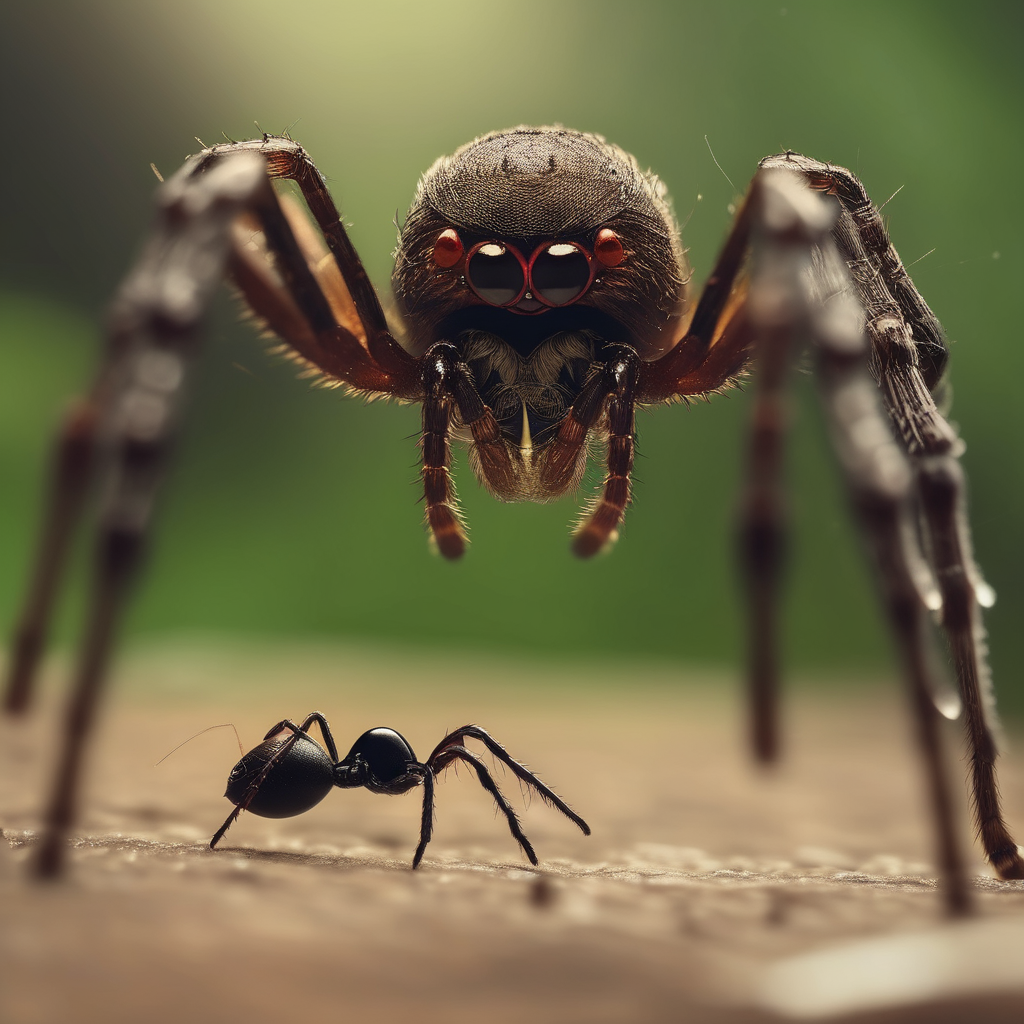

In [19]:
image

In [20]:
image.save("/content/spider.jpg")

# Video generation

In [7]:

%reload_ext autoreload
%autoreload 2


In [8]:
%%capture
try: from torch_snippets import *
except:
  %pip -q install -U diffusers transformers accelerate torch-snippets lovely_tensors torchinfo pysnooper


In [9]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video
from IPython.display import HTML
from base64 import b64encode

pipe = DiffusionPipeline.from_pretrained("damo-vilab/text-to-video-ms-1.7b", torch_dtype=torch.float16, variant="fp16")


model_index.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.82G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
pipe.enable_model_cpu_offload()

In [11]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()

In [12]:
from torchinfo import summary
summary(pipe.unet, depth=4)

Layer (type:depth-idx)                                            Param #
UNet3DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─TransformerTemporalModel: 1-4                                   --
│    └─GroupNorm: 2-4                                             640
│    └─Linear: 2-5                                                164,352
│    └─ModuleList: 2-6                                            --
│    │    └─BasicTransformerBlock: 3-1                            --
│    │    │    └─LayerNorm: 4-1                                   1,024
│   

In [15]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

prompt = 'scooter on a bus'
negative_prompt = 'low quality'
video_duration_seconds = 3
num_frames = video_duration_seconds * 25 + 1
video_frames = pipe(prompt, negative_prompt="low quality", num_inference_steps=25, num_frames=num_frames).frames

def display_video(video):
    fig = plt.figure(figsize=(4.2,4.2))  #Display size specification
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=100, repeat_delay=1000)

    plt.close()
    return anime
video_path = export_to_video(video_frames[0])
video = imageio.mimread(video_path)  #Loading video
HTML(display_video(video).to_html5_video())  #Inline video display in HTML5


  0%|          | 0/25 [00:00<?, ?it/s]